In [4]:
%matplotlib inline
%load_ext watermark

In [5]:
import pandas as pd
import numpy as np
import itertools
from scipy.sparse import csr_matrix
import sklearn
import time
import datetime

In [6]:
%watermark -iv

keras     2.2.4
pandas    0.22.0
numpy     1.14.5
sklearn   0.19.1



In [7]:
# Function to extract info from sparse vectors in string form
def vector_string_to_tuple(string):
    row = string.split("[")
    dim = row[0][1:-1]
    indices = eval('['+row[1][:-1])
    values = eval('['+row[2][:-1])
    return (dim, indices, values)

def get_dim(string):
    return int(string.split(',')[0][0:])

In [8]:
dataset = pd.read_csv('s3://schibsted-spt-common-dev/user-areas/stefano.costantini@schibsted.com/embeddings-experiment/data-for-experiment-csv/year=2018/month=12/day=5/part-00000')

In [9]:
dataset.head()

,gender,demFeatures,numEventsTotal,lookFeatures,age,id
0,1.0,"(1758,[6,9,32,43,46,48,51,62,72,76,80,96,103,1...",20.0,"(28218,[26733,17808,9494,8531],[1.0,1.0,1.0,1.0])",5.0,0
1,0.0,"(1758,[5,8,11,15,19,32,34,39,40,46,47,58,66,69...",437.0,"(28218,[23376,17809,5323,5478,25782,11969,1911...",5.0,1
2,0.0,"(1758,[57,69,110,111,139,237,256,279,298,301,3...",20.0,"(28218,[18455,8062,2565,11949,28095,18580,8531...",5.0,2
3,0.0,"(1758,[0,7,20,25,40,52,62,69,80,84,99,101,105,...",206.0,"(28218,[19013,1225,8530,23481,10954],[1.0,1.0,...",4.0,3
4,0.0,"(1758,[3,30,34,50,103,135,139,141,145,165,168,...",80.0,"(28218,[7109,27250,25065,23246,20583,25858,137...",2.0,4


In [10]:
dataset.shape

(740194, 6)

Remove rows where vector is not expressed in `sparse` format (fix this in Spark!)

In [11]:
dataset_clean = dataset[dataset['demFeatures'].str.contains("\(1758,")]

In [12]:
dataset_clean.shape

(739519, 6)

In [77]:
# Make dataset smaller for speed of prototyping. Will remove later
ds_small = dataset_clean.sample(frac=0.4, replace=False)
ds_small.shape

(295808, 6)

Add flag column to split between training and test

In [78]:
uniform = np.random.uniform(0,1,ds_small.shape[0])
flag = uniform <= 0.8

In [79]:
ds_small['isTraining'] = flag

In [80]:
ds_small.groupby(['isTraining']).count()

,gender,demFeatures,numEventsTotal,lookFeatures,age,id
isTraining,,,,,,
False,59357,59357,59357,59357,59357,59357
True,236451,236451,236451,236451,236451,236451


Split dataset into training and test by adding a flag column

In [81]:
ds = ds_small

## Demographics features

#### Prepare data

(for training and test)
- Extract feature info into 3 separate columns
- Create sparse matrix
- Convert to dense

In [82]:
start = time.time()
ds[['dim', 'indices', 'values']] = ds['demFeatures'].apply(vector_string_to_tuple).apply(pd.Series)
end = time.time()
print('Start: ' + datetime.datetime.fromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S'))
print('End: ' + datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S'))


Start: 2019-01-03 16:18:34
End: 2019-01-03 16:24:44


In [83]:
dem = ds[['gender', 'age', 'dim', 'indices', 'values', 'isTraining']]
dem.head()

,gender,age,dim,indices,values,isTraining
96871,0.0,3.0,1758,"[6, 14, 32, 42, 51, 90, 106, 111, 117, 125, 13...","[0.7576647265975284, 0.7301917969989459, 0.301...",False
231643,0.0,3.0,1758,"[4, 6, 18, 20, 23, 26, 33, 42, 46, 61, 62, 71,...","[0.8474579417380421, 0.7576647265975284, 0.854...",True
226582,0.0,4.0,1758,"[0, 6, 7, 8, 9, 10, 11, 13, 14, 18, 19, 20, 21...","[2.9570266002477417, 3.936941404709105, 3.0539...",True
170526,1.0,6.0,1758,"[50, 69, 86, 105, 139, 189, 197, 203, 216, 222...","[2.102045681115026, 0.33246924679030343, 0.141...",True
724300,0.0,2.0,1758,"[1, 3, 4, 11, 15, 25, 27, 30, 34, 36, 37, 38, ...","[1.0923179968443555, 0.8870621179958298, 0.847...",True


#### Training

In [84]:
dem_train = dem[dem['isTraining'] == True]
dem_train.shape

(236451, 6)

In [85]:
non_empty = [len(x) for x in dem_train['indices'].values]
row_data = [[i]*x for i, x in enumerate(non_empty)]

In [86]:
D = get_dim(dem_train['dim'].values[0])

In [87]:
X = csr_matrix((list(itertools.chain(*dem_train['values'].values)),
                (list(itertools.chain(*row_data)), list(itertools.chain(*dem_train['indices'].values)))),
               shape=(len(dem_train), D))

In [88]:
validation_size = 0.1
validation_rows = int(dem_train.shape[0]*validation_size)
train_features_all = pd.DataFrame(X.toarray())
# Training set
train_features = train_features_all[validation_rows:]
# Validation set
val_features = train_features_all[:validation_rows:]

In [89]:
print(train_features.shape,
      val_features.shape)

(212806, 1758) (23645, 1758)


In [90]:
train_gender_targets_all = dem_train['gender'].values
from keras.utils import to_categorical
train_age_targets_all = to_categorical(dem_train['age'].values)
# Training labels
train_gender_targets = train_gender_targets_all[validation_rows:]
val_gender_targets = train_gender_targets_all[:validation_rows]
train_age_targets = train_age_targets_all[validation_rows:]
val_age_targets = train_age_targets_all[:validation_rows]
print(train_gender_targets.shape,
      val_gender_targets.shape,
      train_age_targets.shape,
      val_age_targets.shape)

(212806,) (23645,) (212806, 8) (23645, 8)


#### Test

In [91]:
dem_test = dem[dem['isTraining'] == False]
dem_test.shape

(59357, 6)

In [92]:
non_empty = [len(x) for x in dem_test['indices'].values]
row_data = [[i]*x for i, x in enumerate(non_empty)]

In [93]:
X = csr_matrix((list(itertools.chain(*dem_test['values'].values)),
                (list(itertools.chain(*row_data)), list(itertools.chain(*dem_test['indices'].values)))),
               shape=(len(dem_test), D))

In [94]:
test_features = pd.DataFrame(X.toarray())

In [95]:
test_gender_targets = dem_test['gender'].values
test_age_targets = to_categorical(dem_test['age'].values)

#### Fitting a model to predict gender and age jointly

In [96]:
from keras.models import Model
from keras import layers
from keras import Input

In [97]:
# Parameters
num_age_groups = train_age_targets.shape[1]
epochs = 10
batch_size = 100

In [98]:
# Defining the model
feature_input = Input(shape=(D,))
x = layers.Dense(D, activation='relu')(feature_input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4, seed=1234)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4, seed=1234)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2, seed=1234)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1, seed=1234)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1, seed=1234)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1, seed=1234)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.1, seed=1234)(x)
x = layers.Dense(16, activation='relu')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)
age_prediction = layers.Dense(num_age_groups, activation='softmax', name='age')(x)

In [99]:
model = Model(feature_input, [gender_prediction, age_prediction])

In [70]:
#model.summary()

In [100]:
model.compile(optimizer='rmsprop',
              loss={'gender': 'binary_crossentropy',
                    'age': 'categorical_crossentropy'},
              loss_weights={'gender': 0.4,
                            'age': 0.6},
              metrics=['accuracy'])

In [101]:
history = model.fit(train_features, 
          {'gender': train_gender_targets,
           'age': train_age_targets},
          epochs=epochs, batch_size=batch_size,
          validation_data=(val_features, 
          {'gender': val_gender_targets,
           'age': val_age_targets}))

Train on 212806 samples, validate on 23645 samples
Epoch 1/10
212806/212806 [==============================] - 37s 172us/step - loss: 1.1667 - gender_loss: 0.5239 - age_loss: 1.5952 - gender_acc: 0.7404 - age_acc: 0.3223 - val_loss: 1.0822 - val_gender_loss: 0.5052 - val_age_loss: 1.4669 - val_gender_acc: 0.7608 - val_age_acc: 0.3735
Epoch 2/10
212806/212806 [==============================] - 34s 159us/step - loss: 1.0668 - gender_loss: 0.4580 - age_loss: 1.4726 - gender_acc: 0.7971 - age_acc: 0.3754 - val_loss: 1.0918 - val_gender_loss: 0.4909 - val_age_loss: 1.4923 - val_gender_acc: 0.7873 - val_age_acc: 0.3589
Epoch 3/10
212806/212806 [==============================] - 34s 158us/step - loss: 1.0386 - gender_loss: 0.4414 - age_loss: 1.4367 - gender_acc: 0.8053 - age_acc: 0.3969 - val_loss: 1.0315 - val_gender_loss: 0.4403 - val_age_loss: 1.4256 - val_gender_acc: 0.8008 - val_age_acc: 0.3978
Epoch 4/10
212806/212806 [==============================] - 34s 157us/step - loss: 1.0147 - ge

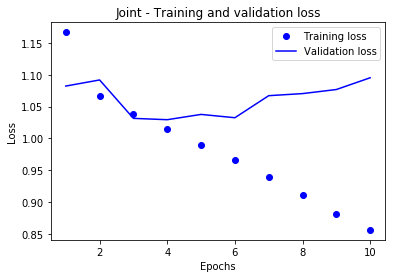

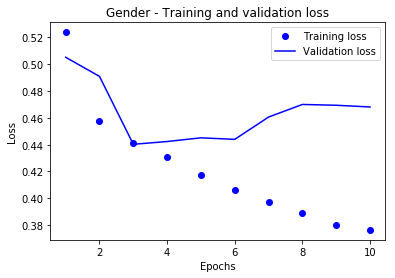

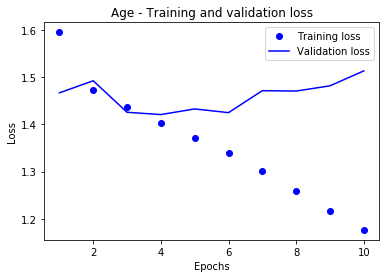

In [102]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Total Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Joint - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gender Loss
loss = history.history['gender_loss']
val_loss = history.history['val_gender_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Gender - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Age Loss
loss = history.history['age_loss']
val_loss = history.history['val_age_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Age - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

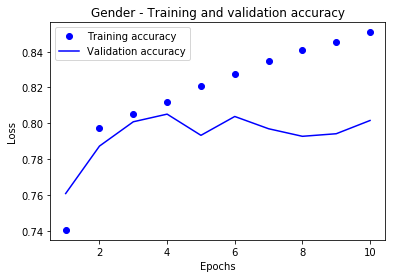

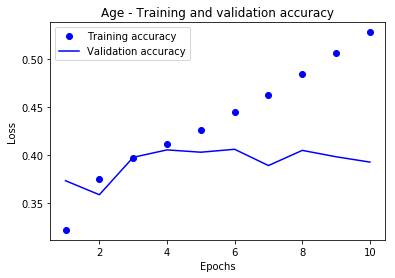

In [103]:
# Gender accuracy
acc = history.history['gender_acc']
val_acc = history.history['val_gender_acc']
epochs = range(1, len(loss) + 1)
plt.subplots(1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Gender - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Age accuracy
acc = history.history['age_acc']
val_acc = history.history['val_age_acc']
epochs = range(1, len(loss) + 1)
plt.subplots(1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Age - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predictions on test set

In [104]:
test_predictions = model.predict(test_features)

In [105]:
test_gender_pred = test_predictions[0]
test_age_pred = test_predictions[1]
print(test_gender_pred.shape, test_age_pred.shape)

(59357, 1) (59357, 8)


In [106]:
test_gender_pred_labels = np.round(test_gender_pred)
test_age_pred_labels = np.argmax(test_age_pred, axis=1)

In [107]:
# Gender
# For comparison, production in NO is:
# Accuracy: 0.830
# AUC: 0.862

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print('Accuracy ', accuracy_score(test_gender_targets, test_gender_pred_labels))
print('AUC ', roc_auc_score(test_gender_targets, test_gender_pred))
print(classification_report(test_gender_targets, test_gender_pred_labels))

Accuracy  0.7995181697188201
AUC  0.8640494547687749
             precision    recall  f1-score   support

        0.0       0.80      0.87      0.84     34984
        1.0       0.79      0.70      0.74     24373

avg / total       0.80      0.80      0.80     59357



In [108]:
# Age
# For comparison, production in NO is:
# Accuracy: 0.446

print('Accuracy ', accuracy_score(np.argmax(test_age_targets, axis=1), test_age_pred_labels))
print(classification_report(np.argmax(test_age_targets, axis=1), test_age_pred_labels))

Accuracy  0.39341610930471554
             precision    recall  f1-score   support

          1       0.20      0.00      0.00       772
          2       0.48      0.29      0.37      6243
          3       0.43      0.44      0.43     13835
          4       0.36      0.44      0.40     13860
          5       0.36      0.47      0.40     12257
          6       0.36      0.27      0.31      7555
          7       0.59      0.33      0.42      4835

avg / total       0.40      0.39      0.39     59357



#### Baseline comparisons

In [109]:
# Gender
# predicting the dominant class
unique, counts = np.unique(test_gender_targets, return_counts=True)
dominant = np.argmax(counts)

test_gender_pred_baseline = np.repeat(dominant, test_gender_pred.shape[0])
test_gender_pred_labels_baseline = np.repeat(dominant, test_gender_pred.shape[0])

print('Accuracy ', accuracy_score(test_gender_targets, test_gender_pred_labels_baseline))
print('AUC ', roc_auc_score(test_gender_targets, test_gender_pred_baseline))
print(classification_report(test_gender_targets, test_gender_pred_labels_baseline))

Accuracy  0.5893828866014118
AUC  0.5
             precision    recall  f1-score   support

        0.0       0.59      1.00      0.74     34984
        1.0       0.00      0.00      0.00     24373

avg / total       0.35      0.59      0.44     59357



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
# Age
# Predicting randomly based on popularity of each class 
unique, counts = np.unique(dem_test['age'].values, return_counts=True)
props = counts / sum(counts)
test_age_pred_labels_baseline = np.random.choice(7, test_age_pred.shape[0], props.any())

print('Accuracy ', accuracy_score(np.argmax(test_age_targets, axis=1), test_age_pred_labels_baseline))
print(classification_report(np.argmax(test_age_targets, axis=1), test_age_pred_labels_baseline))

# Another option is to use the most popular class for everyone. This gives an accuracy of about ~0.24

Accuracy  0.13039742574591034
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.01      0.14      0.02       772
          2       0.10      0.14      0.12      6243
          3       0.24      0.14      0.18     13835
          4       0.23      0.14      0.18     13860
          5       0.20      0.14      0.17     12257
          6       0.13      0.14      0.13      7555
          7       0.00      0.00      0.00      4835

avg / total       0.18      0.13      0.15     59357



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
